# 使用Variational Autoencoder 對手寫數字進行encode 及decode

## 1. 載入keras等套件

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from ipywidgets import interact, FloatSlider, IntSlider

In [4]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda
from keras.layers import Dense #DNN
from keras.layers import Conv2D, MaxPooling2D #CNN
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


## 2. 從mnist資料庫讀入資料

In [5]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

## 3. 確認x資料型態，並將變數修改為1維度的資料，同時將其normalize

In [6]:
x_train = x_train0.reshape(60000, -1) #60000x784
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train / x_train.max()

x_test -= x_test.min()
x_test = x_test / x_test.max()

## 4. 建立Variational autoencoder 模型

In [7]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [8]:
x = Input(shape=(784, ))

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


### 定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer

$X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2, ), mean=0., stddev=1) # X ~N(0, 1)
    return z_mean + epsilon*K.exp(z_log_var / 2)

In [10]:
z = Lambda(sampling, output_shape=(2, ))([z_mean, z_log_var])

In [11]:
x_hat = dec_1(dec_2((z)))

In [12]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

### 定義loss function

In [13]:
def vae_loss(x, x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    KL_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return KL_loss + recovery_loss

## 5. 訓練 VAE(自行訓練發現效果不佳，所以直接使用助教train 出來的weight)

In [14]:
VAE.compile(loss=vae_loss, optimizer=Adam(lr=1e-4))

In [15]:
#VAE.fit(x_train, x_train, batch_size=50, epochs=10)
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 6. 畫出平均數散佈圖

### 定義encoder

In [16]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


### 定義decoder

In [17]:
h_input = Input(shape=(2, ))
VAE_decoder = Model(h_input, dec_1(dec_2((h_input))))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### 抽出3000筆testing data 進行繪圖

In [18]:
indices = np.random.randint(10000, size=3000)
VAE_latent = VAE_encoder.predict(x_test[indices])
VAE_latent.shape

(3000, 2)

Text(0, 0.5, 'mean[1]')

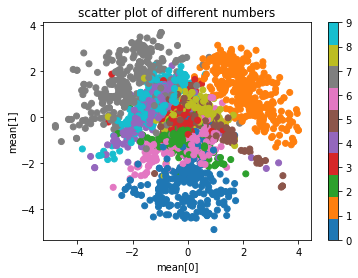

In [19]:
plt.scatter(VAE_latent[:, 0], VAE_latent[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()
plt.title('scatter plot of different numbers')
plt.xlabel('mean[0]')
plt.ylabel('mean[1]')

## 7. 根據decoder 繪製還原後的數字

### 定義normalize 函式

In [20]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

### 將長寬各切成15 等分進行繪製

In [21]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
vae_figure = np.zeros((digit_size*n, digit_size*n))

for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        vae_figure[(n-i-1)*digit_size: (n-i)*digit_size, 
                               j*digit_size: (j+1)*digit_size] = normalized(digit)

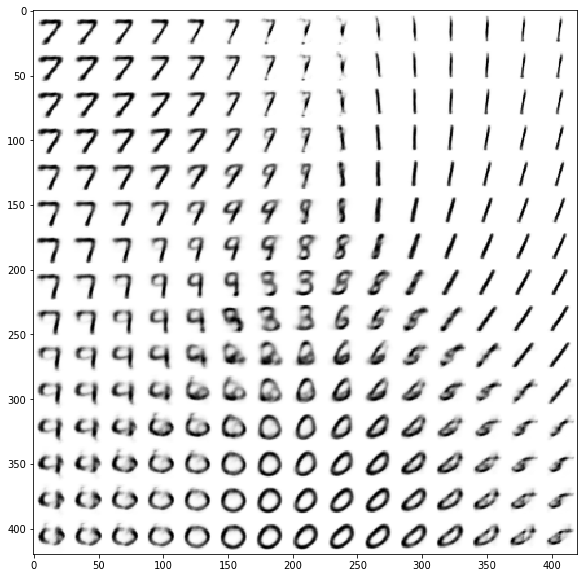

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(vae_figure, cmap='Greys')
plt.show()

## 8. 動態比較

### 建立list 存取0~9數字對應的index

In [23]:
num_to_index = [[] for i in range(0, 10)]
for i in range(0, 60000):
    num_to_index[y_train0[i]] += [i]
    
idx_1 = 0
idx_2 = 9

### 定義inbetween 函式進行繪圖

* **start_num:**   
開始數字，函式會自動從所有label為start_num的training data中抽出其中一項，並且將其顯示  
* **end_num:**   
結束數字，函式會自動從所有label為end_num的training data中抽出其中一項，並且將其顯示  
* **t:**   
在開始數字和結束數字之間的比例

In [24]:
def inBetween(t, start_num, end_num):
    global idx_1
    global idx_2
    
    ## 只有start_num or end_num被更改時才重新抽樣
    if(idx_1 not in num_to_index[start_num]):
        idx_1 = random.choice(num_to_index[start_num])
    if(idx_2 not in num_to_index[end_num]):
        idx_2 = random.choice(num_to_index[end_num])
    
    # 根據index取得784 為的data
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*data_0 + t*data_1
    
    # 使用encoder 壓縮為2 維平均數
    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(2, 1, 2)
    ax1.set_title('Two dimensional mean')
    ax1.set_xlabel('mean[0]')
    ax1.set_ylabel('mean[1]')

    # 以平均數為座標繪製散布圖
    ax1.scatter(mu_0[0], mu_0[1], label='start_num')
    ax1.scatter(mu_1[0], mu_1[1], label='end_num')
    ax1.scatter(mu_t[0], mu_t[1])
    ax1.annotate(start_num, (mu_0[0], mu_0[1]))
    ax1.annotate(end_num, (mu_1[0], mu_1[1]))
    ax1.annotate('(' + str(mu_t[0]) + ', ' + str(mu_t[1]) + ')', (mu_t[0], mu_t[1]))
    
    # 以start_num和end_num的平均數為端點的斜直線
    ax1.legend()
    ax1.plot([mu_0[0], mu_1[0]], [mu_0[1], mu_1[1]], ls='--', alpha=0.7)
    
    # 繪製start_num
    ax2 = plt.subplot(2, 3, 1)
    ax2.set_title('start_num')
    ax2.imshow(data_0, cmap='Greys')
    
    # 繪製t
    ax3 = plt.subplot(2, 3, 2)
    ax3.set_title('middle_num')
    ax3.imshow(data_t, cmap='Greys')
    
    # 繪製end_num
    ax4 = plt.subplot(2, 3, 3)
    ax4.set_title('end_num')
    ax4.imshow(data_1, cmap='Greys')

In [25]:
interact(inBetween, start_num=IntSlider(value=0, min=0, max=9), 
                            t=FloatSlider(value=0.5, min=0, max=1.0,step=0.05),  
                            end_num=IntSlider(value=9, min=0, max=9))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), IntSlider(value=0, descript…

<function __main__.inBetween(t, start_num, end_num)>

nbviewer 無法顯示interact，所以以下用些許截圖代表

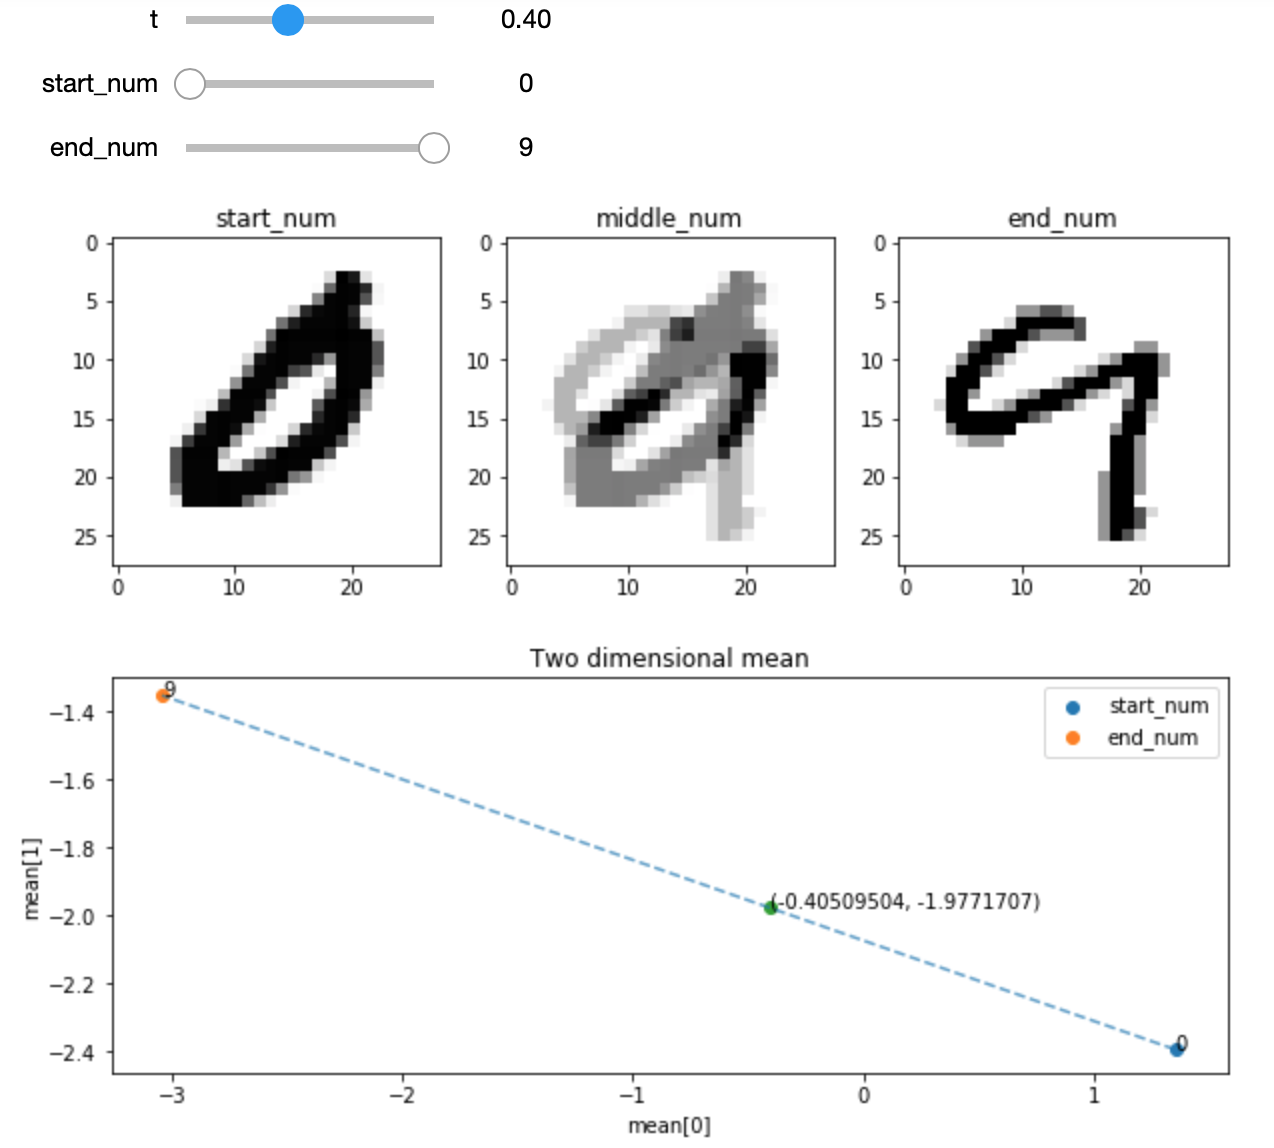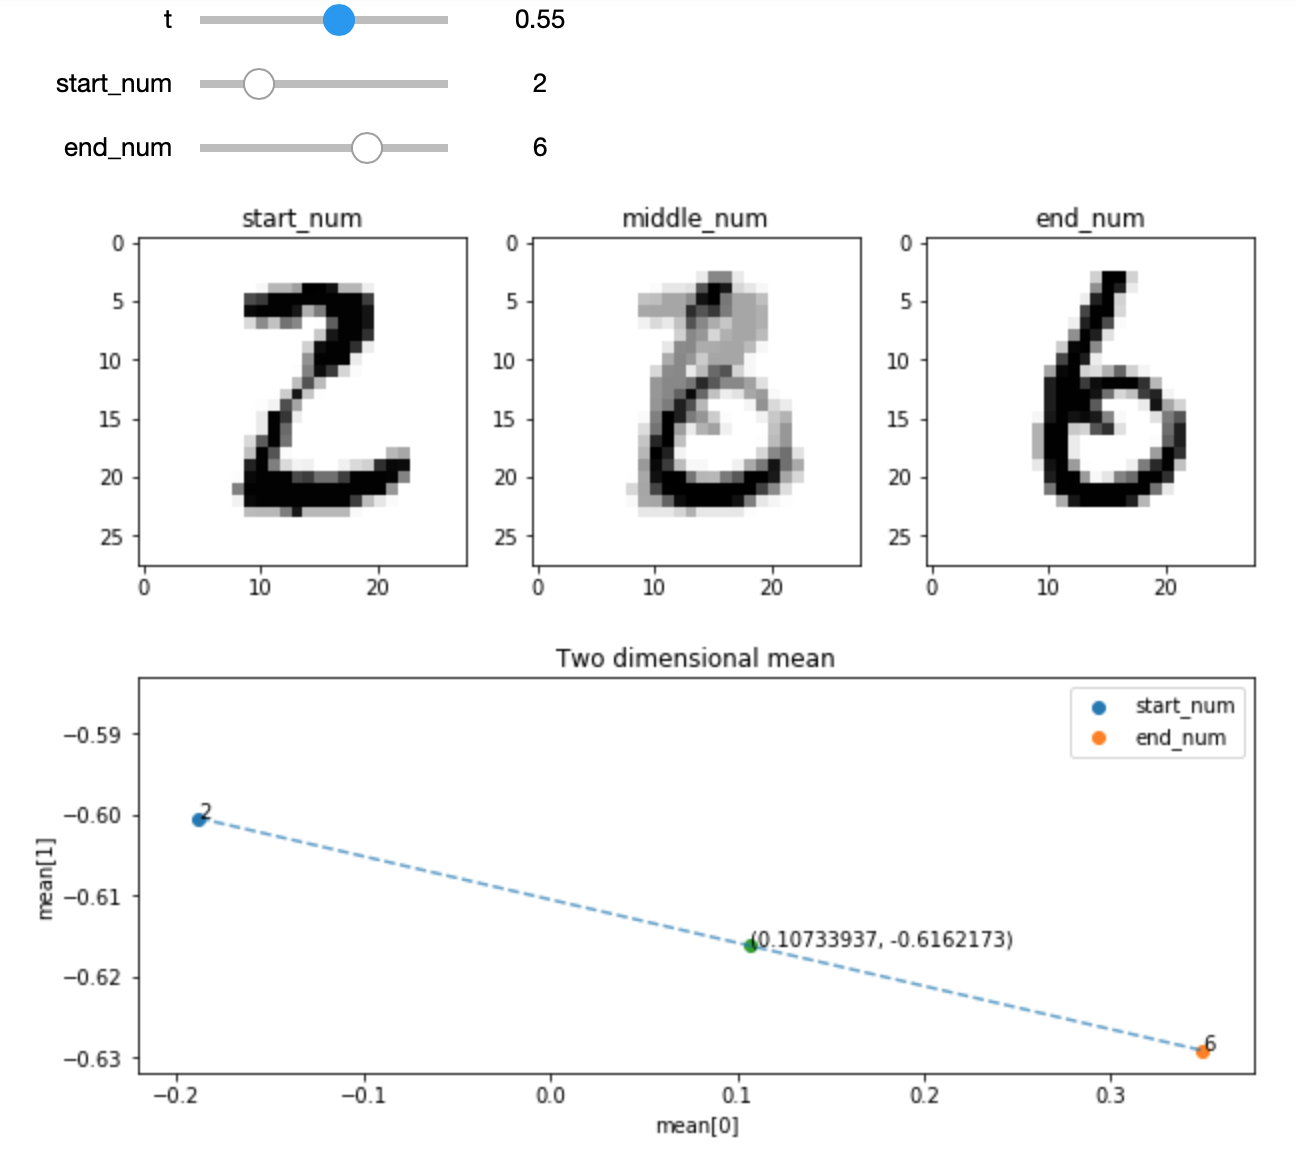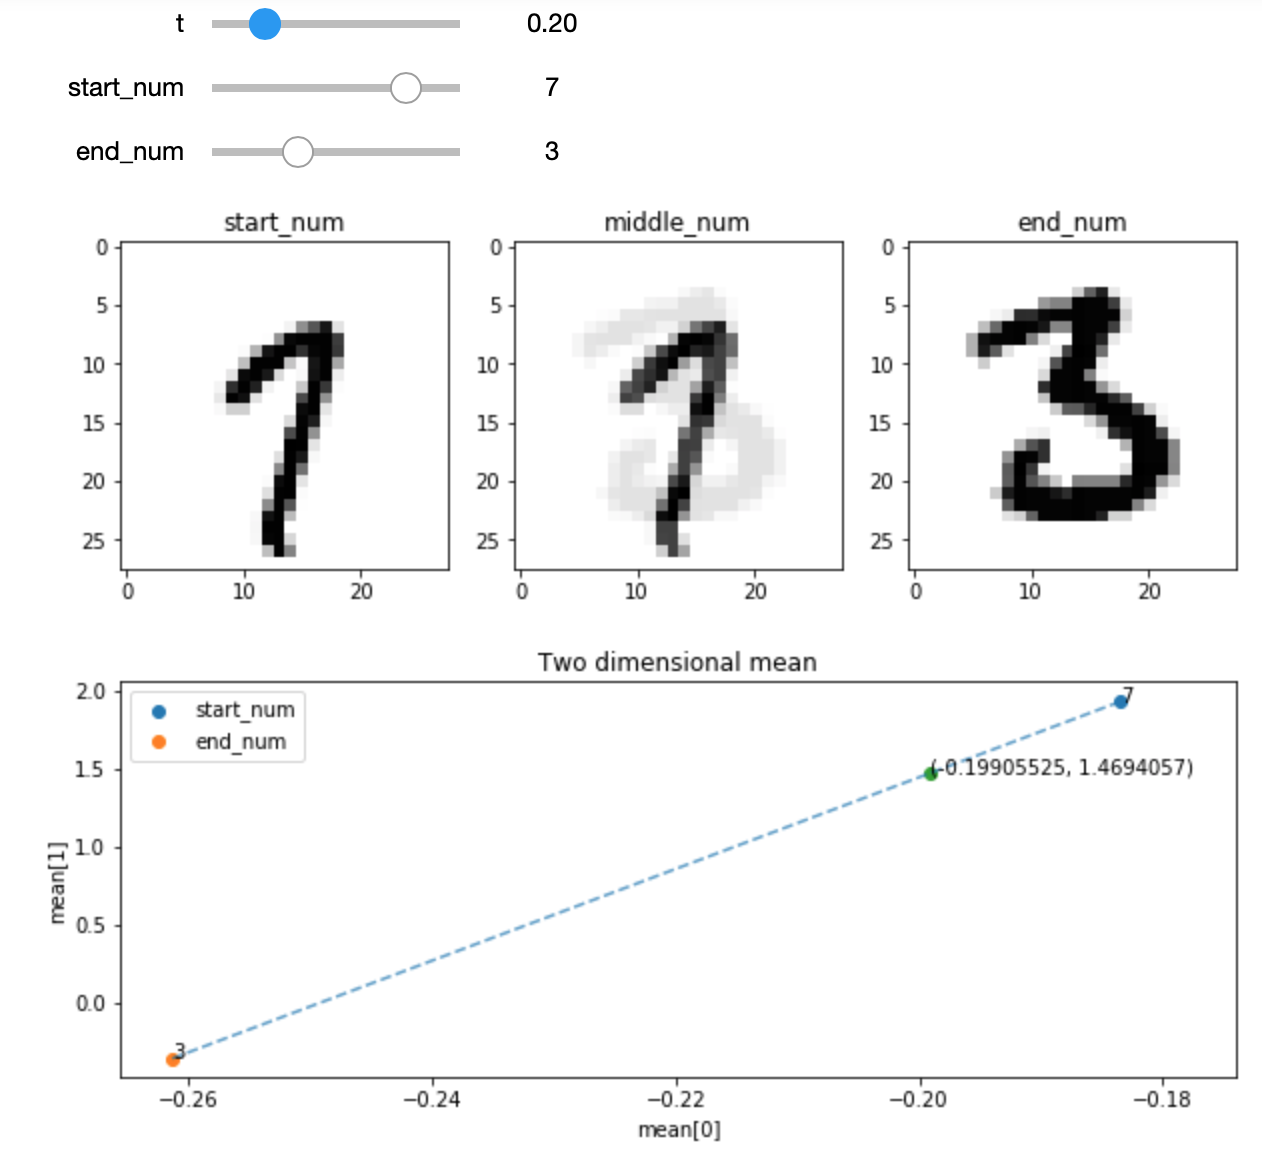